# Problem 1 - Digit Recognizer

### Imports

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
import tensorflow as tf 

import numpy as np
import matplotlib.pyplot as plt
import warnings, math

warnings.filterwarnings("ignore")

### The dataset

In [14]:
data = np.load('dataset.npz')
X = data['X']
y = data['y']

labels_dict = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9',
    10: 'A',
    11: 'B',
    12: 'C',
    13: 'D',
    14: 'E',
    15: 'F',
    16: 'Empty'
}

### Splitting the dataset

In [15]:
seed = 13
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

### Visualizing data

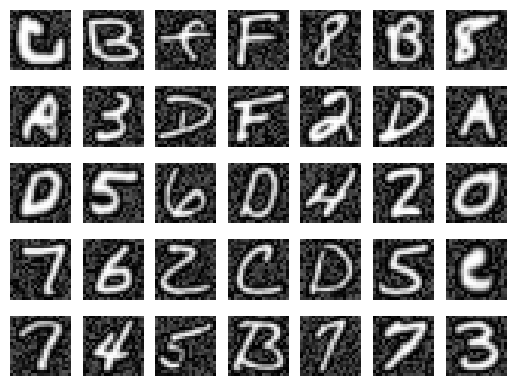

In [16]:
fig, axes = plt.subplots(5, 7)
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(20, 20), vmin=0, vmax=255, cmap='gray')
    ax.axis('off')
plt.show()

### Visualizing data by class

In [ ]:
fig, axes = plt.subplots(3, 6, figsize=(6, 6))
axes = axes.ravel()
np.random.seed(42)

for class_label in range(17):
    class_indices = np.where(y_train == class_label)[0]
    random_index = np.random.choice(class_indices)
    
    axes[class_label].imshow(X_train[random_index].reshape(20, 20), vmin=0, vmax=255, cmap='gray')
    axes[class_label].axis('off')
    axes[class_label].set_title(labels_dict[class_label])
     
axes[-1].axis('off')
plt.tight_layout()
plt.show()

### Data Preprocessing

In [17]:
X_train_norm = X_train / 255.0
X_test_norm = X_test / 255.0

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_norm)
X_test = scaler.transform(X_test_norm)

### Model selection - Classifier 1

Here I use SVM

In [18]:
param_grid = {
    'C': [0.1, 1, 10], 
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

grid_svc = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_svc.fit(X_train, y_train)

print("Best parameters for SVM:", grid_svc.best_params_)
best_svc = grid_svc.best_estimator_

y_pred_svc = best_svc.predict(X_test)
print(f"SVM Classification Report:\n{classification_report(y_test, y_pred_svc)}")

Best parameters for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       188
           1       0.92      0.96      0.94        69
           2       0.94      0.89      0.91       158
           3       0.94      0.95      0.94       285
           4       0.90      0.90      0.90       150
           5       0.93      0.89      0.91       209
           6       0.96      0.96      0.96       274
           7       0.92      0.95      0.93       182
           8       0.87      0.85      0.86       128
           9       0.95      0.87      0.91        61
          10       0.91      0.94      0.92       248
          11       0.87      0.83      0.85       157
          12       0.94      0.98      0.96       285
          13       0.88      0.92      0.90       273
          14       1.00      0.55      0.71        22
          15       0.87      0.87      

### Model selection - Classifier 2

Here I use Random forest

In [19]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7]
}

grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best parameters for Random Forest:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

y_pred_rf = best_rf.predict(X_test)
print(f"Random Forest Classification Report:\n{classification_report(y_test, y_pred_rf)}")

Best parameters for Random Forest: {'max_depth': 7, 'n_estimators': 200}
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       188
           1       0.88      0.87      0.88        69
           2       0.94      0.59      0.73       158
           3       0.68      0.94      0.79       285
           4       0.77      0.77      0.77       150
           5       0.82      0.64      0.72       209
           6       0.82      0.92      0.86       274
           7       0.76      0.92      0.83       182
           8       0.75      0.57      0.65       128
           9       1.00      0.13      0.23        61
          10       0.69      0.96      0.80       248
          11       0.76      0.45      0.57       157
          12       0.75      0.96      0.84       285
          13       0.76      0.78      0.77       273
          14       0.00      0.00      0.00        22
          15       0.89  

### Model selection - Classifier 3

Here i use neaural network.

In [33]:
num_class = len(labels_dict)

# reshape data
X_train_tf = X_train.reshape(-1, 20, 20)
X_test_tf = X_test.reshape(-1, 20, 20)

# Add layers
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(20, 20)))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(num_class, activation='softmax'))  

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(X_train_tf, y_train, epochs=10)

# Evaluate the model
loss, tf_accuracy = model.evaluate(X_test_tf, y_test)


Epoch 1/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 741us/step - accuracy: 0.5635 - loss: 1.5265
Epoch 2/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.8955 - loss: 0.3558
Epoch 3/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.9474 - loss: 0.1908
Epoch 4/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.9712 - loss: 0.1115
Epoch 5/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.9941 - loss: 0.0504
Epoch 6/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.9960 - loss: 0.0294
Epoch 7/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.9999 - loss: 0.0140
Epoch 8/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.9999 - loss: 0.0087
Epoch 9/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 1.0000 - loss: 0.0055
Epoch 10/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 1.0000 - loss: 0.0036
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - accuracy: 0.8975 - loss: 0.4639


### Classifier Evaluation

In [32]:
svc_accuracy = accuracy_score(y_test, y_pred_svc)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"SVM Test Accuracy: {svc_accuracy:0.3f}")
print(f"Random Forest Test Accuracy: {rf_accuracy:0.3f}")
print(f"Neural network Accuracy: {tf_accuracy:0.3f}")

best_model_2 = max(svc_accuracy, rf_accuracy, tf_accuracy)

best_model = best_svc

SVM Test Accuracy: 0.920
Random Forest Test Accuracy: 0.777
Neural network Accuracy: 0.890


### Vizulize the predicted data with confusion matrix
// Remove before delivering

How to read the table: 
- Take the value at row 0, column 0, which is 140. This means that for 140 instances, the true label was 0, and the classifier also predicted 0.
- Now, look at row 0, column 14, which is 30. This means that for 30 instances, the true label was 0, but the classifier incorrectly predicted label 14. 

In [ ]:
y_pred_test = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.show()

### Testing the classifier agianst the unseen data

In [ ]:
num_samples = 8
indices = np.random.choice(len(X_test), num_samples, replace=False)
sample_images = X_test[indices]
sample_true_labels = y_test[indices]
sample_predicted_labels = y_pred_svc[indices]

fig, axes = plt.subplots(1, num_samples, figsize=(13, 4))  
for i in range(num_samples):
    ax = axes[i]
    ax.imshow(sample_images[i].reshape(20, 20), cmap='gray')
    ax.axis('off')

    actual = labels_dict[sample_true_labels[i]]
    predicted = labels_dict[sample_predicted_labels[i]]

    if actual == predicted:
        color = 'green'
    else:
        color = 'red'

    ax.set_title(f"Actual: {actual}", fontsize=10)
    ax.text(0.5, -0.15, f"Predicted: {predicted}", fontsize=10, color=color, ha='center', va='top', transform=ax.transAxes)

plt.subplots_adjust(wspace=0.5) 

plt.show()

# Problem 2: Dimensionality Reduction

### Standardize the data

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Determine Optimal Number of Components

In [ ]:
pca = PCA().fit(X_train_scaled)

plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_) * 100)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

We can choose $k$ such that we retain, for example, 95% of the variance.

In [ ]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

k = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components explaining 95% variance: {k}")

### Transform Data Using PCA

In [20]:
pca = PCA(n_components=k)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

### Train Classifier on Reduced Data

In [ ]:
svc = SVC(C=10, gamma='scale', kernel='rbf', random_state=42)
svc.fit(X_train_pca, y_train)

### Evaluate performance

In [ ]:
y_pred_pca = svc.predict(X_test_pca)

accuracy_pca = accuracy_score(y_test, y_pred_pca)

print(f"Test Accuracy with PCA: {accuracy_pca:.3f}")
print(f"Classification Report with PCA:\n{classification_report(y_test, y_pred_pca)}")

# Problem 3: Detecting Out-of-Distribution Images

### The dataset

In [3]:
corrupted_data = np.load('corrupt_dataset.npz')
X_corrupted = corrupted_data['X']

### Visualisation of the corrupted data

We have normal data, but  it seem to inlcude images of clohtes like pants, sweater, dress too. 

In [ ]:
num_images = 16

plt.figure(figsize=(5, 5))
indices = np.random.choice(len(X_corrupted), num_images, replace=False)
for i, idx in enumerate(indices):
    image = X_corrupted[idx].reshape(20, 20)
    plt.subplot(4, 4, i + 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Using One-Class SVM to detect outliers

In [ ]:
# TODO: Test with others like Isolation Forest,  Local Outlier Factor, ...
X_corrupted_scaled = scaler.transform(X_corrupted)
X_corrupted_pca = pca.transform(X_corrupted_scaled)

ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.04)
ocsvm.fit(X_train_pca)

predictions = ocsvm.predict(X_corrupted_pca)

inlier_indices = np.where(predictions == 1)[0]
outlier_indices = np.where(predictions == -1)[0]

print(f"Number of inliers (numbers/letters): {len(inlier_indices)}")
print(f"Number of outliers (possibly clothes): {len(outlier_indices)}")

### Visualisation of the outliers

As you can see. It detected many of them. Pants, shoes, empty images, bags. But it also got some wrong.

In [ ]:
num_images = len(outlier_indices)
cols = 12
rows = math.ceil(num_images / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
axes = axes.flatten()
for i, idx in enumerate(outlier_indices):
    image = X_corrupted[idx].reshape(20, 20)
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')

for i in range(len(outlier_indices), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()